In [34]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm


from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder

from astropy.stats import mad_std
import time

from lvmtipo.actors import lvm
from lvmagp.focus import Focus


In [35]:
from logging import DEBUG

#from sdsstools.logger import StreamFormatter
#from sdsstools import get_logger, read_yaml_file
#from sdsstools.logger import SDSSLogger

import numpy as np

from astropy.coordinates import SkyCoord, Angle
import astropy.wcs
import astropy.units as u

#from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection

from scipy.ndimage import median_filter

In [36]:
import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

from IPython.display import clear_output

In [37]:
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz,ICRS

import astrometry
solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={5,6},
    )
)

import spherepoints


In [38]:


import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import colors


from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)


ellipse = lambda c: Ellipse(xy=(c['x'], c['y']),
                            width=8*c['a'],
                            height=8*c['b'],
                            angle=c['theta'] * -180. / np.pi)

def plot_catalog(ax, catalog, color="red", cat_max=8, cat_rest=None):
     for c in catalog[:cat_max]:
         e = ellipse(c)
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)
     if cat_rest:
         for c in catalog[cat_max+1:]:
             e = ellipse(c)
             e.set_facecolor('none')
             e.set_edgecolor("white")
             ax.add_artist(e)

def plot_centroid(ax, catalog, color="white"):
     catalog = catalog.transpose()
     for c in catalog:
         e = ellipse({'x': c[0], 'y': c[1], 'a': 8, 'b': 8, 'theta': 0})
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)

def plot_images(images, vmin=None, vmax=None, rotate=None, cat_max = 8, cat_rest = None, cat_extra=None, figsize=None, wcs=None):
    data = images[0].data
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.5)
    median = np.median(data)

    
    args={}
#    fig, ax = plt.subplots(1, ncols=(len(images)))
#    fig, ax = plt.subplots(1, ncols=(len(images)), dpi=100)
    fig, ax = plt.subplots(1, ncols=(len(images)), figsize=figsize if figsize else (8, 5/len(images)), *args)
#    fig, ax = plt.subplots(nrows=(len(images)), figsize=(16,9))
    
    fig.canvas.toolbar_visible = 'fade-in-fade-out'
#    fig.canvas.footer_visible = False
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'left'
    is_single_image = len(images) > 1


    for idx, img in enumerate(images):
        if rotate and rotate[idx]:
            data = np.copy(img.data).transpose()
        else:
            data = img.data

        ax_idx = ax[idx] if is_single_image else ax
        ax_idx.set_title(img.header["CAMNAME"])
        ax_idx.scatter([img.data.shape[1]/2], [img.data.shape[0]/2], marker='+', s=40, color='red')
#        ax_im = ax_idx.imshow(data,
#                              vmin=vmin if vmin else median,
#                              vmax=vmax if vmax else uperc)
        if wcs: 
            # wcs = WCS(hdu.header)
            print(wcs)

        ax_im = ax_idx.imshow(data,
                              norm=PowerNorm(1.4,
                                             vmin=vmin if vmin else median,
                                             vmax=vmax if vmax else uperc,
                                             clip=True,
                                            )
                             )

        

        ax_idx.invert_yaxis()
        fig.colorbar(ax_im, cax=make_axes_locatable(ax_idx).append_axes('right', size='3%', pad=0.05), orientation='vertical')
      
        if img.catalog:
            plot_catalog(ax_idx, img.catalog, "red", cat_max, cat_rest)

        if cat_extra:
            plot_catalog(ax_idx, cat_extra[idx], "yellow")

        if hasattr(img, "centroid"):
            plot_centroid(ax_idx, img.centroid, "white")

    # plt.scatter(x, y, marker='+', s=40, color='red')

    fig.tight_layout()
    plt.show()
    
from lvmagp.focus.focusseries.base import FocusSeries
from lvmagp.focus.curvefit import fit_hyperbola
from lvmagp.images import Image

import matplotlib.pyplot as plt


def callback(data):
    if isinstance(data[0], Image):
        for idx, img in enumerate(data):
            print(f"cam: {img.header['CAMNAME']} focus: {img.header['FOCUSDT']} srcs: {len(img.catalog)}")
        plot_images(data)
    elif isinstance(data[0], tuple):
        fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(10, 5/len(data)))

        for idx, d in enumerate(data):
            camera = d[0]
            dd = d[1]
            focus = [d["focus"] for d in dd]
            r = [d["r"] for d in dd]
            rerr = [d["rerr"] for d in dd]

            ax_idx = ax[idx] if len(data) > 1 else ax
            ax_idx.set_title(camera)
            ax_idx.errorbar(focus, r, yerr=rerr)

async def foc_series(do_home=False):
    
    if do_home:
        await lvm.skyw.foc.moveToHome()
    
    focvals = await focus.fine(exposure_time=7.0, guess=36.07, count=5, step=0.3, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

    with fits.open(filenames[0]) as hdul:
        data_east = hdul[0].data

    with fits.open(filenames[1]) as hdul:
        data_west = hdul[0].data

    image_list = [data_east,data_west]

    fig,(ax1,ax2) = plt.subplots(figsize=(8,8),ncols=2)
    ax1.imshow(data_east.T,norm=LogNorm(vmin=50, vmax=1000))
    ax2.imshow(data_west.T,norm=LogNorm(vmin=50, vmax=1000))
    fig.suptitle("best focus images")
    plt.show()
    return filenames

async def find_foc(guess=40.):
    focvals = await focus.fine(exposure_time=10.0, guess=guess, count=5, step=0.5, callback=callback)
    print(focvals)
    best_focus_position = np.nanmean(focvals, axis=0)
    print("best focus",np.nanmean(focvals, axis=0))
    if np.isnan(best_focus_position[0]):
        print("no focus found for this field!")
        return
    await focus.position(best_focus_position[0])
    exptime = 5
    rc = await tel.agc.expose( exptime)
    filenames = rc.flatten().unpack("*.filename")
    print("best focus images:", filenames)

In [39]:
# select telescope
tel = lvm.skye


await tel.start()

focus = Focus(tel)

await tel.foc.status()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': 40.468,
 'DeviceEncoder': {'Position': 234.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}

In [40]:
plot = False

alt,az = spherepoints.uniform_points(n=240,minimum_alt=30)

az = az[np.flip(np.argsort(alt))]
alt = alt[np.flip(np.argsort(alt))]

#alt = np.array([0.5*np.pi])
#az = np.array([0])

theta = 0.5*np.pi - alt

r = 1

x = r * np.sin( theta) * np.cos( az )
y = r * np.sin( theta) * np.sin( az )
z = r * np.cos(theta)

if plot:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_box_aspect(aspect=(1,1,1))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    #ax.set_aspect("equal")#
    ax.plot(x,y,z,"ko")

959.9999999999998


In [10]:
await tel.agc.status()
await tel.pwi.findHome()

{'dec_j2000_degs': -16.7239073561922,
 'ra_j2000_hours': 6.75233374115487,
 'axis0': {'position_degs': 107.784419491525},
 'axis1': {'position_degs': 34.0760021186441}}

In [11]:
current_alt = 80./180.*np.pi
current_az = 180./180.*np.pi

observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
observing_time = Time.now()

current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
current_icrs = current_aa.transform_to(ICRS)
print(current_aa)
print(current_icrs)

rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

<SkyCoord (AltAz: obstime=2023-03-08 00:59:29.700140, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>
<SkyCoord (ICRS): (ra, dec) in deg
    (109.4540139, -38.95802779)>
ra_h:dec_d 7.29692637406889:-38.9581093793787


cam: east focus: 37.5 srcs: 2
cam: west focus: 37.5 srcs: 4


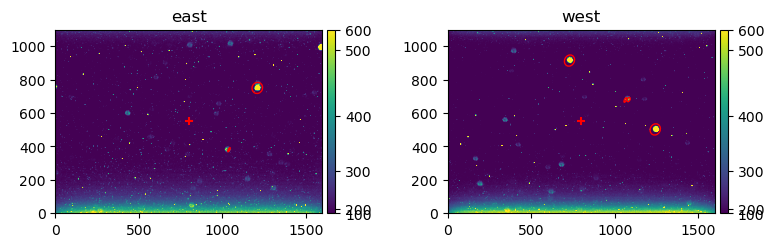

cam: east focus: 38.0 srcs: 3
cam: west focus: 38.0 srcs: 4


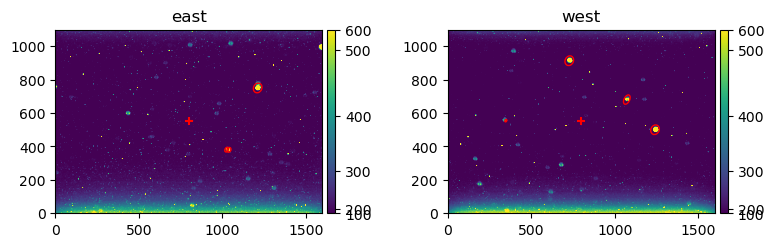

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 5.5+-3.4.


cam: east focus: 38.5 srcs: 6
cam: west focus: 38.5 srcs: 11


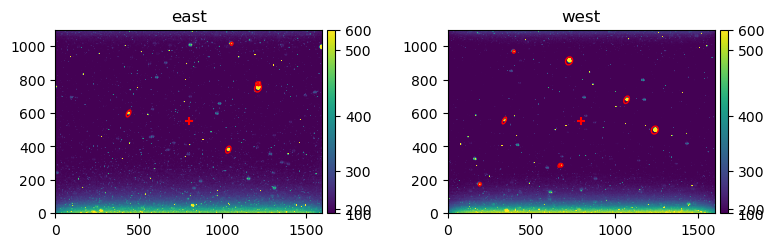

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.5+-3.0.


cam: east focus: 39.0 srcs: 8
cam: west focus: 39.0 srcs: 14


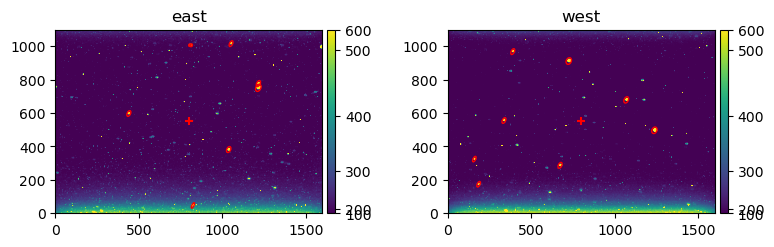

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.6+-0.6.


cam: east focus: 39.5 srcs: 23
cam: west focus: 39.5 srcs: 19


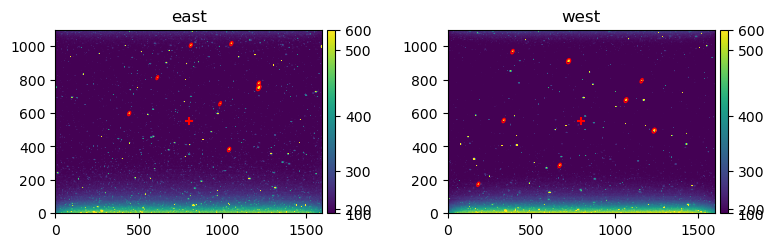

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.3+-0.5.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.7+-0.5.


cam: east focus: 40.0 srcs: 30
cam: west focus: 40.0 srcs: 27


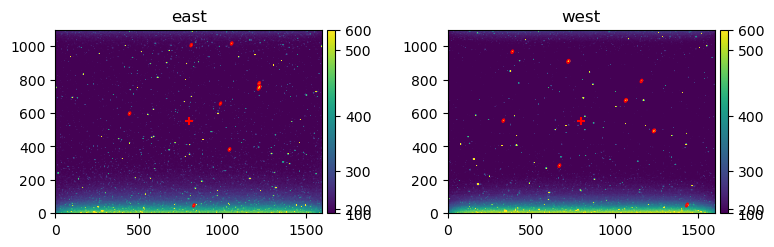

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.3+-0.3.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 3.6+-0.4.


cam: east focus: 40.5 srcs: 28
cam: west focus: 40.5 srcs: 24


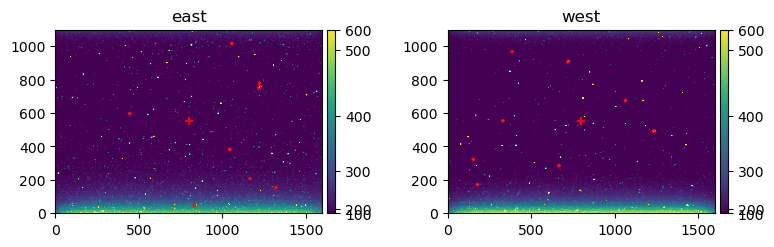

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.2+-0.8.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 4.6+-0.8.


cam: east focus: 41.0 srcs: 26
cam: west focus: 41.0 srcs: 23


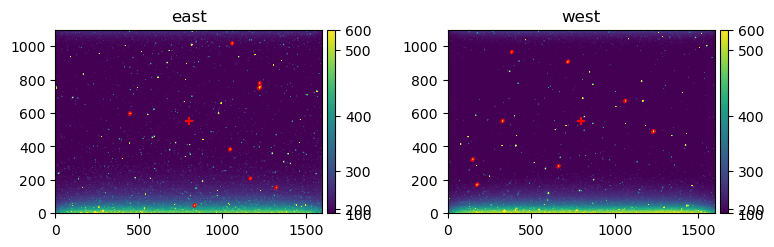

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 6.8+-1.1.
INFO:lvmagp.focus.focusseries.photometry:Found median radius of 7.3+-0.8.


cam: east focus: 41.5 srcs: 15
cam: west focus: 41.5 srcs: 17


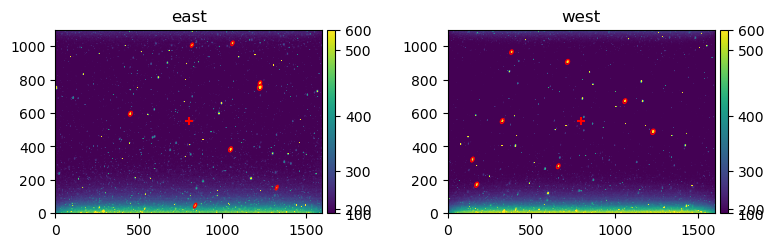

INFO:lvmagp.focus.focusseries.photometry:Found median radius of 9.6+-1.8.


cam: east focus: 42.0 srcs: 6
cam: west focus: 42.0 srcs: 12


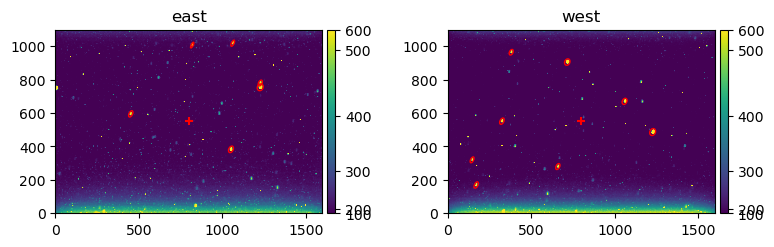

cam: east focus: 42.5 srcs: 4
cam: west focus: 42.5 srcs: 7


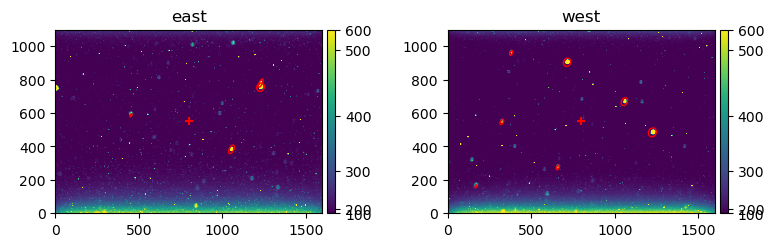

DEBUG:lvm_tel_focus:foc move to position 40.46989942088484 dt


[[4.04949586e+01 1.24776035e-03]
 [4.04448402e+01 5.67348213e-03]]
best focus [4.04698994e+01 3.46062124e-03]
best focus images: ['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000012.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000012.fits']


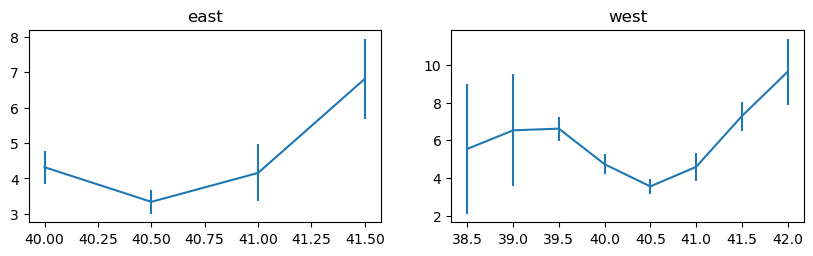

In [13]:
await find_foc()

In [14]:
await tel.km.moveToHome()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': -135.0,
 'DeviceEncoder': {'Position': 0.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': True,
 'CurrentTime': 843379389.0,
 'Simulate': False,
 'SkyPA': -270.0}

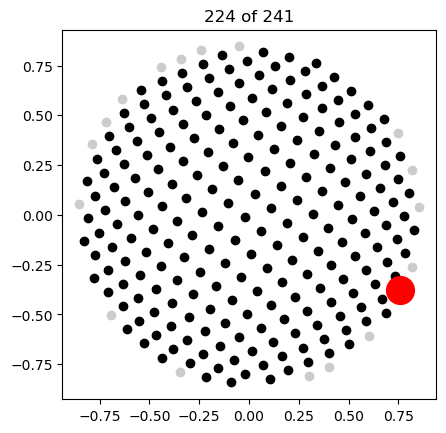

0.5621788226932143 -0.46107023980869594
km at:  {'Position': 66.2679999798732}
<SkyCoord (AltAz: obstime=2023-03-08 03:25:04.534653, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (333.5826212, 32.21047387)>
<SkyCoord (ICRS): (ra, dec) in deg
    (121.49836423, 23.91139046)>
ra_h:dec_d 8.09989505104743:23.9115432281316
km at:  {'Position': 66.2679999798732}
km at:  {'Position': 5.676333319265694}
km at:  {'Position': 5.718499985928133}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000259.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000293.fits']
---------------------------------


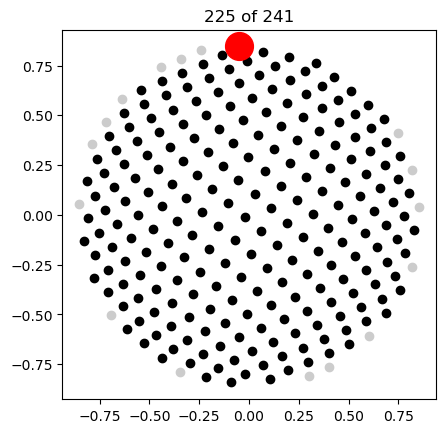

0.5599903352512194 1.6320249408007548
km at:  {'Position': 5.721722208150055}
<SkyCoord (AltAz: obstime=2023-03-08 03:25:28.653012, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (93.50814117, 32.08508278)>
<SkyCoord (ICRS): (ra, dec) in deg
    (208.47525202, -17.51684089)>
ra_h:dec_d 13.8983532134587:-17.5169838721551
km at:  {'Position': 5.721722208150055}
km at:  {'Position': -88.52966667131369}
km at:  {'Position': -88.48594444909585}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000260.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000294.fits']
---------------------------------


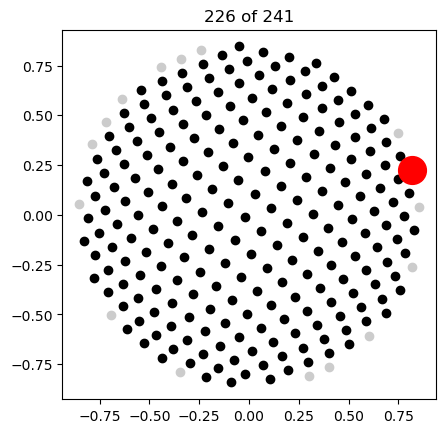

0.5576336495364073 0.2673934188933572
km at:  {'Position': -88.4830000046517}
<SkyCoord (AltAz: obstime=2023-03-08 03:25:54.045667, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (15.32051437, 31.95005463)>
<SkyCoord (ICRS): (ra, dec) in deg
    (160.65013917, 27.45423748)>
ra_h:dec_d 10.7100107879704:27.4541826283621
km at:  {'Position': -88.4830000046517}
km at:  {'Position': -35.569555565498604}
km at:  {'Position': -35.511666676615505}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000261.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000295.fits']
---------------------------------


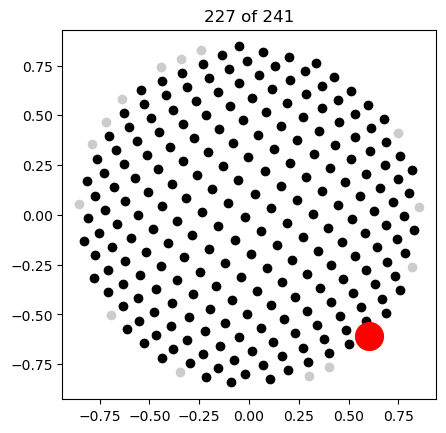

0.54887142002005 -0.7897122364972619
km at:  {'Position': -35.50694445439376}
<SkyCoord (AltAz: obstime=2023-03-08 03:26:15.057069, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (314.75282182, 31.44801586)>
<SkyCoord (ICRS): (ra, dec) in deg
    (107.08782075, 15.84076884)>
ra_h:dec_d 7.13919428581201:15.8407083243623
km at:  {'Position': -35.50694445439376}
km at:  {'Position': 8.821111096728998}
km at:  {'Position': 8.848055541170737}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000262.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000296.fits']
---------------------------------


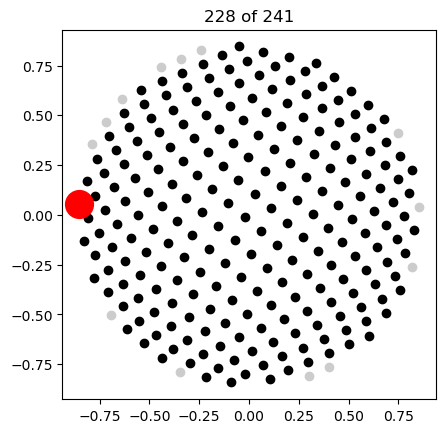

0.5484784120977776 3.079230405138253
km at:  {'Position': 8.850222207837191}
<SkyCoord (AltAz: obstime=2023-03-08 03:26:37.050037, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (176.42690636, 31.42549817)>
<SkyCoord (ICRS): (ra, dec) in deg
    (196.66332358, -85.95577582)>
ra_h:dec_d 13.1109097079164:-85.9557948548549
km at:  {'Position': 8.850222207837191}
km at:  {'Position': 79.79566664518708}
km at:  {'Position': 79.82305553407323}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000263.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000297.fits']
---------------------------------


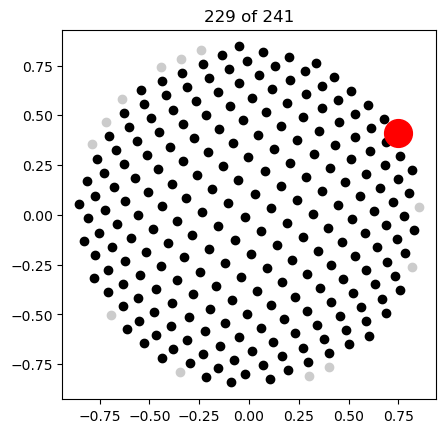

0.5459684434909648 0.500097211334084
km at:  {'Position': 79.82505553407304}
<SkyCoord (AltAz: obstime=2023-03-08 03:27:01.071218, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (28.65345956, 31.28168756)>
<SkyCoord (ICRS): (ra, dec) in deg
    (172.94472793, 23.96710074)>
ra_h:dec_d 11.5296493444875:23.967036009454
km at:  {'Position': 79.82505553407304}
km at:  {'Position': -49.807166675185954}
km at:  {'Position': -49.734833341859854}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000264.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000298.fits']
---------------------------------


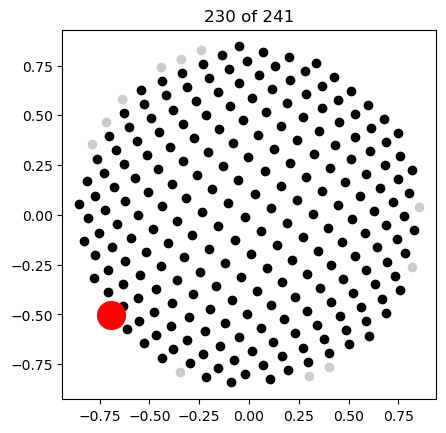

0.5453687710184815 -2.5116381937219354
km at:  {'Position': -49.73038889741585}
<SkyCoord (AltAz: obstime=2023-03-08 03:27:29.358304, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (216.09373184, 31.24732886)>
<SkyCoord (ICRS): (ra, dec) in deg
    (69.92220229, -58.87857797)>
ra_h:dec_d 4.66148445962341:-58.8785812928694
km at:  {'Position': -49.73038889741585}
km at:  {'Position': -24.92355556656321}
km at:  {'Position': -24.910000011009004}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000265.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000299.fits']
---------------------------------


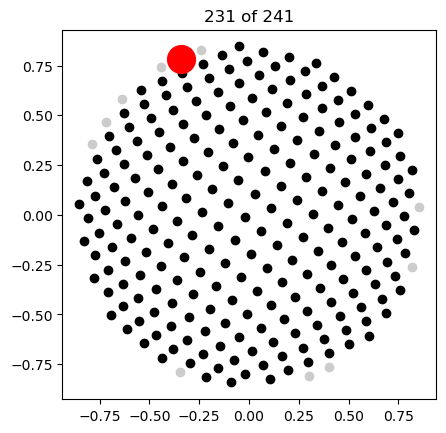

0.544016170059361 1.9794146846575922
km at:  {'Position': -24.9085555665647}
<SkyCoord (AltAz: obstime=2023-03-08 03:27:50.515976, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (113.41210734, 31.16983053)>
<SkyCoord (ICRS): (ra, dec) in deg
    (216.36410825, -33.14650436)>
ra_h:dec_d 14.4242743705524:-33.1465249880589
km at:  {'Position': -24.9085555665647}
km at:  {'Position': 81.94461108941664}
km at:  {'Position': 81.98894442274553}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000266.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000300.fits']
---------------------------------


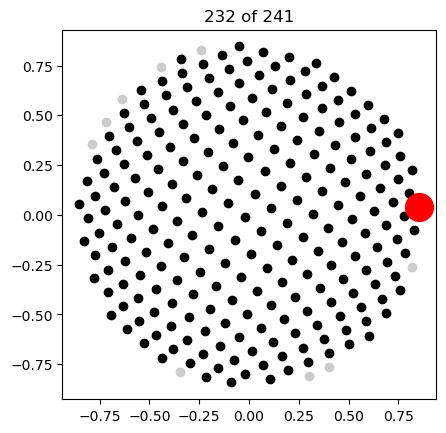

0.5419861245686464 0.04505141556906892
km at:  {'Position': 81.99177775607859}
<SkyCoord (AltAz: obstime=2023-03-08 03:28:17.176221, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (2.58125597, 31.05351749)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.16545261, 30.003161)>
ra_h:dec_d 9.94436449571008:30.0031632761511
km at:  {'Position': 81.99177775607859}
km at:  {'Position': -19.32916667823376}
km at:  {'Position': -19.251111122685998}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000267.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000301.fits']
---------------------------------


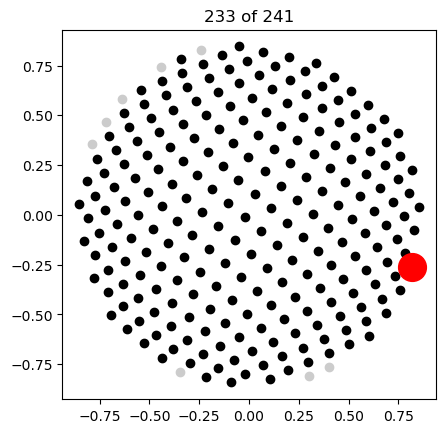

0.5401463100575578 -0.31012547405322727
km at:  {'Position': -19.246166678242048}
<SkyCoord (AltAz: obstime=2023-03-08 03:28:42.141704, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (342.23111922, 30.94810389)>
<SkyCoord (ICRS): (ra, dec) in deg
    (129.51099312, 27.78774441)>
ra_h:dec_d 8.63407094837941:27.7877143036193
km at:  {'Position': -19.246166678242048}
km at:  {'Position': 2.579999986242001}
km at:  {'Position': 2.6189444306825465}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000268.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000302.fits']
---------------------------------


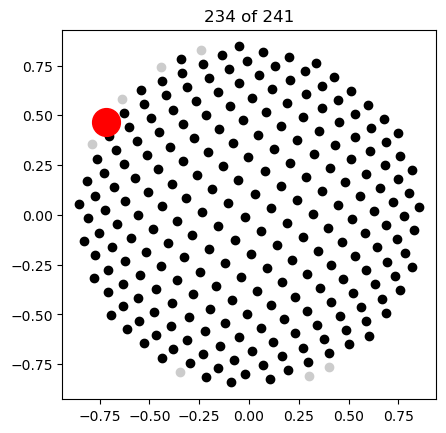

0.5391148685027076 2.5645126798637885
km at:  {'Position': 2.623055541793235}
<SkyCoord (AltAz: obstime=2023-03-08 03:29:00.163141, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (146.93575306, 30.88900664)>
<SkyCoord (ICRS): (ra, dec) in deg
    (224.58104997, -61.30254434)>
ra_h:dec_d 14.9720825519255:-61.3026091804792
km at:  {'Position': 2.623055541793235}
km at:  {'Position': 69.0176666462649}
km at:  {'Position': 69.05172220181703}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000269.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000303.fits']
---------------------------------


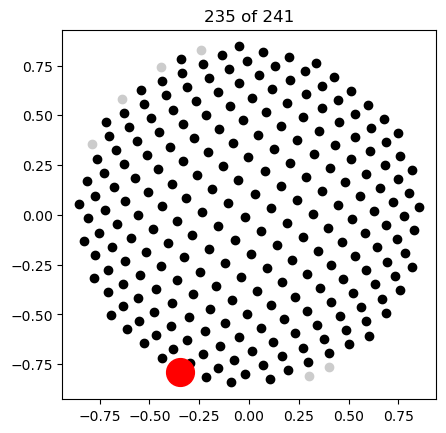

0.5354816316358422 -1.9850535126978353
km at:  {'Position': 69.0543333129279}
<SkyCoord (AltAz: obstime=2023-03-08 03:29:24.275759, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (246.26481161, 30.6808375)>
<SkyCoord (ICRS): (ra, dec) in deg
    (76.49758375, -33.40480436)>
ra_h:dec_d 5.09984687037366:-33.4048724230093
km at:  {'Position': 69.0543333129279}
km at:  {'Position': -12.515611123359548}
km at:  {'Position': -12.49805556780575}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000270.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000304.fits']
---------------------------------


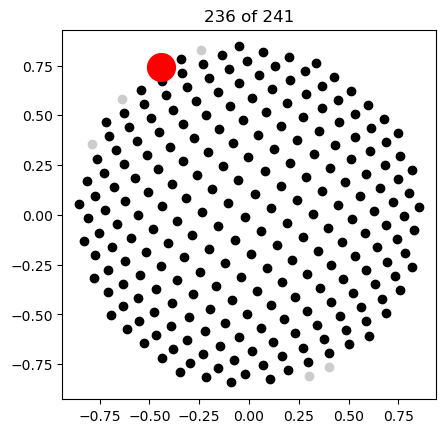

0.5314065150877647 2.106333354244688
km at:  {'Position': -12.496777790028105}
<SkyCoord (AltAz: obstime=2023-03-08 03:29:49.190474, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (120.68401145, 30.44735052)>
<SkyCoord (ICRS): (ra, dec) in deg
    (219.74707564, -38.98555686)>
ra_h:dec_d 14.6498059920206:-38.9856830053203
km at:  {'Position': -12.496777790028105}
km at:  {'Position': 78.2757777564502}
km at:  {'Position': 78.31633331200169}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000271.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000305.fits']
---------------------------------


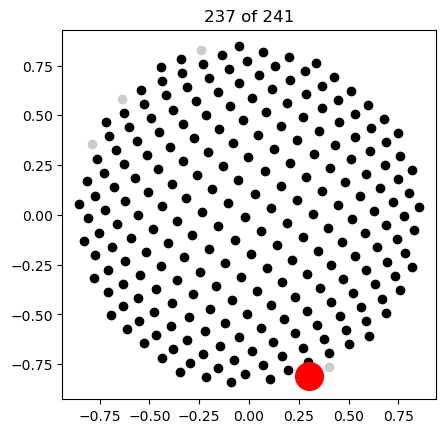

0.5306478843356696 -1.2139088916596723
km at:  {'Position': 78.31916664533475}
<SkyCoord (AltAz: obstime=2023-03-08 03:30:15.283052, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (290.44814379, 30.40388418)>
<SkyCoord (ICRS): (ra, dec) in deg
    (93.22196769, 1.04713972)>
ra_h:dec_d 6.21480618241223:1.04714077316363
km at:  {'Position': 78.31916664533475}
km at:  {'Position': 4.3819999860618}
km at:  {'Position': 4.403388874948547}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000272.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000306.fits']
---------------------------------


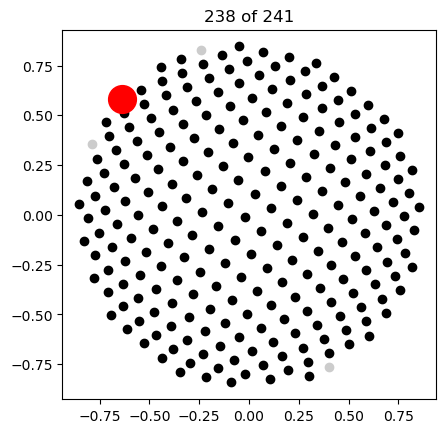

0.5296538498105565 2.4000215596433363
km at:  {'Position': 4.404888874948398}
<SkyCoord (AltAz: obstime=2023-03-08 03:30:40.636586, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (137.51110611, 30.3469302)>
<SkyCoord (ICRS): (ra, dec) in deg
    (224.25297676, -53.18615501)>
ra_h:dec_d 14.9502029035578:-53.1862035865903
km at:  {'Position': 4.404888874948398}
km at:  {'Position': 71.49494442379495}
km at:  {'Position': 71.53022220156919}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000273.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000307.fits']
---------------------------------


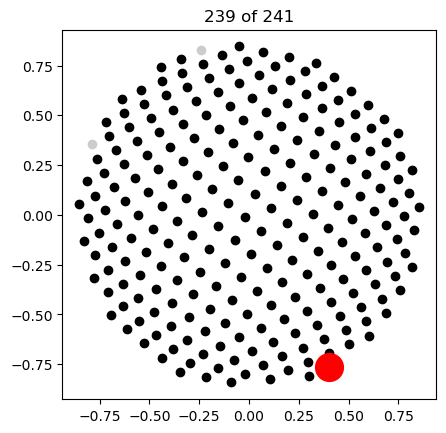

0.5295175168978008 -1.0878341540105976
km at:  {'Position': 71.53266664601338}
<SkyCoord (AltAz: obstime=2023-03-08 03:31:05.060505, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (297.67169417, 30.3391189)>
<SkyCoord (ICRS): (ra, dec) in deg
    (97.11355654, 6.07918271)>
ra_h:dec_d 6.4742513810569:6.07928851417911
km at:  {'Position': 71.53266664601338}
km at:  {'Position': 6.593333319174008}
km at:  {'Position': 6.615166652505138}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000274.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000308.fits']
---------------------------------


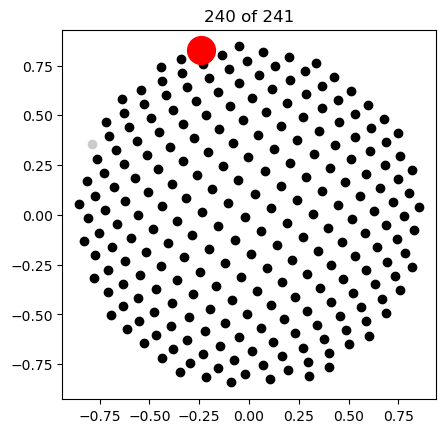

0.5284660301460635 1.8547960565626433
km at:  {'Position': 6.616833319171633}
<SkyCoord (AltAz: obstime=2023-03-08 03:31:29.347045, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (106.2719859, 30.27887314)>
<SkyCoord (ICRS): (ra, dec) in deg
    (216.09407145, -27.03108209)>
ra_h:dec_d 14.4062737085312:-27.0311618158862
km at:  {'Position': 6.616833319171633}
km at:  {'Position': 84.44466664472219}
km at:  {'Position': 84.48433331138489}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000275.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000309.fits']
---------------------------------


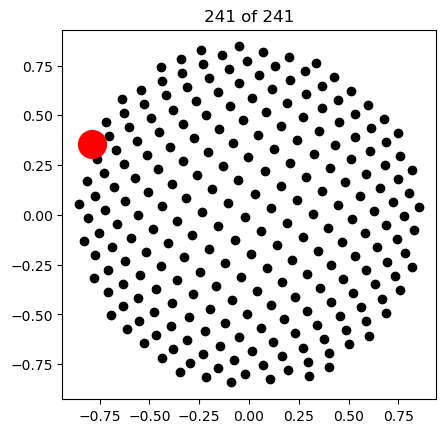

0.5280985884820611 2.7199649372001136
km at:  {'Position': 84.48716664471795}
<SkyCoord (AltAz: obstime=2023-03-08 03:31:54.885815, location=(1845655.49905341, -5270856.2947176, -3075330.77760682) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (155.84251133, 30.25782029)>
<SkyCoord (ICRS): (ra, dec) in deg
    (227.91001007, -68.92009851)>
ra_h:dec_d 15.1940119366063:-68.9201330721254
km at:  {'Position': 84.48716664471795}
km at:  {'Position': 65.70783331326254}
km at:  {'Position': 65.73244442437118}
['/data/lvm/skye/agcam/east/20230308/lvm.skye.agcam.east_00000276.fits', '/data/lvm/skye/agcam/west/20230308/lvm.skye.agcam.west_00000310.fits']
---------------------------------


In [41]:
show_2d_plot = True

start_from = 224



for index in range(len(alt)):
    if index<start_from-1:
        continue
    current_alt = alt[index]
    current_az = az[index]
    if show_2d_plot:
        fig,ax = plt.subplots()
        ax.set_aspect("equal")
        ax.plot(x[:index],y[:index],"ko")
        ax.plot(x[index:],y[index:],"o",color="0.8")
        ax.plot(x[index],y[index],"ro",ms=20)
        ax.set_title("{} of {}".format(index+1,len(alt)))
        plt.show()

    print(current_alt,current_az)
    
    
    observing_location = EarthLocation.of_site("Las Campanas Observatory")#(lat='52.2532', lon='351.63910339111703', height=100*u.m)  
    observing_time = Time.now()
    
    await tel.km.slewStop()
    #await tel.km.moveToHome()
    print("km at: ",await tel.km.getPosition())
    
    current_aa = SkyCoord(alt=current_alt*u.rad, az = current_az*u.rad, frame='altaz', obstime=Time.now(), location=observing_location)
    
    current_icrs = current_aa.transform_to(ICRS)
    print(current_aa)
    print(current_icrs)
    
    rc = await tel.pwi.gotoRaDecJ2000(current_icrs.ra.hour,current_icrs.dec.deg)
    ra_h, dec_d = rc.flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
    print(f"ra_h:dec_d {ra_h}:{dec_d}")

    # dont do that on every exposure if you didn't change the pointing
    print("km at: ",await tel.km.getPosition())
    await tel.km.slewStart(ra_h, dec_d)
    print("km at: ",await tel.km.getPosition())
    
    #input("Telescope slewing done... proceed?")
    
    rc = await tel.agc.expose(7.)
    print("km at: ",await tel.km.getPosition())
    filenames = rc.flatten().unpack("*.filename")
    print(filenames)
    print("---------------------------------")

In [43]:
await tel.km.moveToHome()
await tel.km.slewStop() # has to be done, otherwise k-mirror will rotate until it hits a limit
await tel.km.moveAbsolute(90., "DEG") # parking position (all mirror surfaces vertical)
await tel.pwi.park() # goto park position
await tel.pwi.setEnabled(False) # disengage motors (telescope should be free floating now)

{'is_enabled': False,
 'axis0': {'is_enabled': False},
 'axis1': {'is_enabled': False}}

In [27]:
await tel.km.getPosition()


{'Position': -135.0}

In [28]:
print(ra_h, dec_d)
await tel.km.slewStart(ra_h, dec_d)

5.26705200522024 -56.7042351614226


{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': -32.9291111213182,
 'DeviceEncoder': {'Position': 1837276.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False,
 'CurrentTime': 851610783.0,
 'Simulate': False,
 'SkyPA': -65.85822222426364}